## Sprint 1: Preliminary Analysis and ETL Pipeline Construction 

### Step 1: Clone the template repository which contains the datasets.

In [6]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '4g')
    .getOrCreate()
)

In [7]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pandas import date_range
import glob
sc_conf = SparkConf().setAppName('test')

merchant_data = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/merchant_fraud_probability.csv')
consumerf_data = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/consumer_fraud_probability.csv')
consumer_data = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/tbl_consumer.csv',sep = '|')
user_consumer = spark.read.parquet('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/consumer_user_details.parquet')
user_consumer = user_consumer.toPandas()

print('null value count merchant--',merchant_data.isnull().sum())
print('null value count consumer--',consumer_data.isnull().sum())
print('null value count consumerf--',consumerf_data.isnull().sum())
# These three datasets have no null value

null value count merchant-- merchant_abn         0
order_datetime       0
fraud_probability    0
dtype: int64
null value count consumer-- name           0
address        0
state          0
postcode       0
gender         0
consumer_id    0
dtype: int64
null value count consumerf-- user_id              0
order_datetime       0
fraud_probability    0
dtype: int64


### Step 2: Use Pyspark to get transactions data and generate the ETL

In [8]:
def etl_pipeline(merchant_data, consumer_data,consumerf_data,ifsave=False):

    # # Merging data sets
    merchant_data['order_datetime']= pd.to_datetime(merchant_data['order_datetime'])
    consumerf_data['order_datetime']= pd.to_datetime(consumerf_data['order_datetime'])
    dftmp = pd.merge(merchant_data,consumerf_data,on = 'order_datetime')
    dftmp = pd.merge(dftmp,user_consumer,on = 'user_id')
    df = pd.merge(dftmp,consumer_data,on = 'consumer_id')
    df = df.sort_values(by='order_datetime')
    # A total of 32009 data from 2021-03-25 to 2022-02-27

    df_final = pd.DataFrame()
    date_list = date_range(start='2021-03-25', end='2022-02-27')
    for d in date_list:
        file = glob.glob("../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/transactions/order_datetime="+str(d)[:10]+'/*.parquet')
        if len(file)==1:
            df_parquet = spark.read.parquet(file[0])
            df_parquet = df_parquet.toPandas()
            df_parquet['order_datetime'] = str(d)[:10]
            df_parquet['order_datetime'] = pd.to_datetime(df_parquet['order_datetime'])
            dftmp = pd.merge(df,df_parquet,on = ['order_datetime','user_id','merchant_abn'],how = 'inner')
            if len(dftmp)>0:
                df_final = pd.concat([df_final,dftmp])
    if ifsave:
        df.to_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/df.csv')
        df_final.to_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/dffinal.csv')
    return df,df_final


### Step 3:  preliminary analysis

       merchant_abn  fraud_probability
count  1.140000e+02         114.000000
mean   5.440738e+10          40.419335
std    3.172677e+10          17.187745
min    1.114906e+10          18.210891
25%    2.173151e+10          28.992765
50%    4.942497e+10          32.692032
75%    8.491712e+10          48.395260
max    9.998904e+10          94.134700
            postcode   consumer_id
count  499999.000000  4.999990e+05
mean     4037.085418  7.508952e+05
std      1791.076639  4.331004e+05
min       200.000000  4.000000e+00
25%      2619.000000  3.760505e+05
50%      3807.000000  7.516370e+05
75%      5350.000000  1.126366e+06
max      9999.000000  1.499995e+06
            user_id  fraud_probability
count  34864.000000       34864.000000
mean   12057.003930          15.120091
std     6963.195641           9.946085
min        1.000000           8.287144
25%     6059.750000           9.634437
50%    12067.500000          11.735624
75%    18091.250000          16.216158
max    24081.000000   

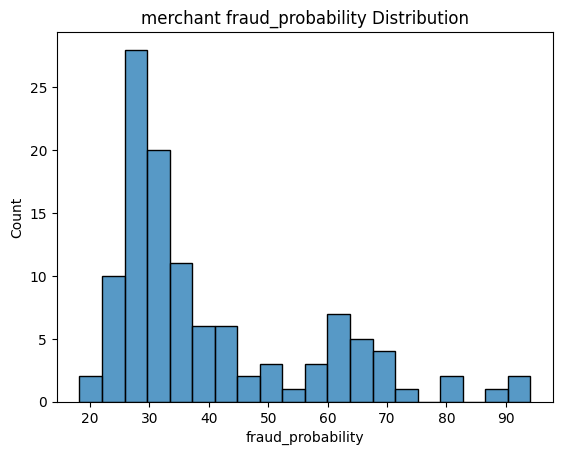

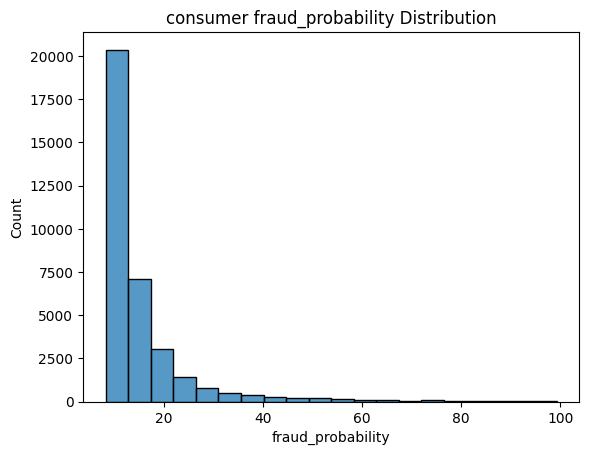

In [9]:
# View statistical information about the dataset. 
print(merchant_data.describe())
print(consumer_data.describe())
print(consumerf_data.describe())

# Data Distribution Visualisation
sns.histplot(merchant_data['fraud_probability'], bins=20)
plt.title('merchant fraud_probability Distribution')
plt.show()

sns.histplot(consumerf_data['fraud_probability'], bins=20)
plt.title('consumer fraud_probability Distribution')
plt.show()



### Step4: External dataset

In [10]:
# External data set, consumer index (monthly)
external_df = pd.read_excel('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/ABS_CPI_M_1+3...50.M.xlsx')
external_df.head(2)



,Time Period,Time Period.1,Feb 2021,Mar 2021,Apr 2021,May 2021,Jun 2021,Jul 2021,Aug 2021,Sep 2021,...,Jun 2022,Jul 2022,Aug 2022,Sep 2022,Oct 2022,Nov 2022,Dec 2022,Jan 2023,Feb 2023,Unnamed: 27
0,All groups CPI,NaN,105.3,105.6,106.1,106.2,106.4,106.7,107.0,107.3,...,113.6,114.4,114.7,115.0,115.4,116.4,118.2,117.8,118.0,NaN
1,· Health,NaN,108.9,111.1,113.4,113.4,112.8,112.8,112.8,112.7,...,115.5,115.5,115.5,115.8,115.8,117.0,117.2,118.1,118.1,NaN
